In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Load Fashion MNIST dataset
(x_train, _), (_, _) = fashion_mnist.load_data()

# Normalize the images
x_train = x_train / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=3)

# Define the dimensions of the noise vector
latent_dim = 100

# Generator model
generator = Sequential([
    Dense(128 * 7 * 7, input_dim=latent_dim),
    LeakyReLU(0.2),
    Reshape((7, 7, 128)),
    BatchNormalization(),
    Flatten(),
    Dense(128 * 7 * 7),
    LeakyReLU(0.2),
    Reshape((7, 7, 128)),
    BatchNormalization(),
    Flatten(),
    Dense(28 * 28, activation='tanh'),
    Reshape((28, 28, 1))
])

# Discriminator model
discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128),
    LeakyReLU(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

# Combine the generator and discriminator into a single model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy',
            optimizer=Adam(lr=0.0002, beta_1=0.5))



In [15]:
# Training the GAN
#epochs = 200
epochs = 1000
batch_size = 128

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, fake_labels)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | Discriminator Loss: {d_loss[0]} | Generator Loss: {g_loss}")



4/4 [==============================] - 0s 2ms/step
Epoch 0/1000 | Discriminator Loss: 0.46496088802814484 | Generator Loss: 3.1421289443969727
4/4 [==============================] - 0s 3ms/step
Epoch 100/1000 | Discriminator Loss: 0.3798348903656006 | Generator Loss: 3.023554801940918
4/4 [==============================] - 0s 3ms/step
Epoch 200/1000 | Discriminator Loss: 0.29970160126686096 | Generator Loss: 3.539720296859741
4/4 [==============================] - 0s 2ms/step
Epoch 300/1000 | Discriminator Loss: 0.430599182844162 | Generator Loss: 3.973384141921997
4/4 [==============================] - 0s 3ms/step
Epoch 400/1000 | Discriminator Loss: 0.2927575260400772 | Generator Loss: 3.688533306121826
4/4 [==============================] - 0s 4ms/step
Epoch 500/1000 | Discriminator Loss: 0.22811982035636902 | Generator Loss: 3.5669655799865723
4/4 [==============================] - 0s 3ms/step
Epoch 600/1000 | Discriminator Loss: 0.2093864530324936 | Generator Loss: 4.3130426406860

1/1 [==============================] - 0s 34ms/step


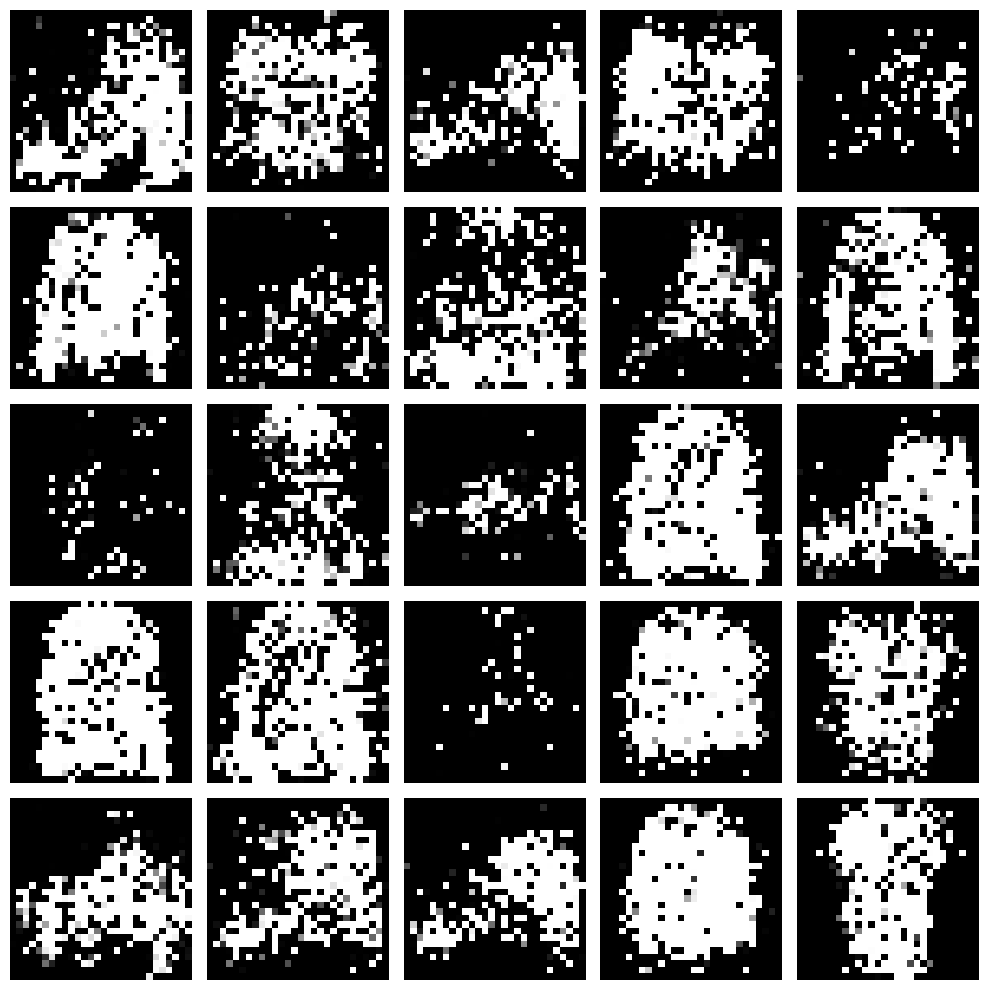

In [16]:
# Generate images
rows, cols = 5, 5
noise = np.random.normal(0, 1, (rows * cols, latent_dim))
generated_images = generator.predict(noise)

# Plot generated images
plt.figure(figsize=(10, 10))
for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow((generated_images[i].reshape(28, 28) + 1) / 2, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
